# Example working with OSM data and tc and river flood with climate change 

In [1]:
import geocoder


ModuleNotFoundError: No module named 'geocoder'

In [1]:
from shapely import wkt
import numpy as np
import pandas as pd
import geopandas as gpd
from climada.entity import Exposures
from climada.entity.impact_funcs import ImpactFunc, ImpactFuncSet
from climada.engine import Impact


health_df = pd.read_excel('locations_preprocessed.xlsx')
health_df = health_df[['name','geometry','Level']]
health_df.rename(columns={'Level':'impf_id'})
health_df['geometry'] = health_df['geometry'].apply(wkt.loads)
health_df = gpd.GeoDataFrame(
    health_df, geometry=health_df.geometry)

health_exposure = Exposures(health_df)
health_exposure.gdf['longitude'] = health_exposure.gdf['geometry'].centroid.x
health_exposure.gdf['latitude'] = health_exposure.gdf['geometry'].centroid.y
health_exposure.set_crs('epsg:4326')



/var/folders/f5/lms0b90j1kx7kk4v552qkjqw0000gp/T/ipykernel_66518/2268534461.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  health_exposure.gdf['longitude'] = health_exposure.gdf['geometry'].centroid.x
/var/folders/f5/lms0b90j1kx7kk4v552qkjqw0000gp/T/ipykernel_66518/2268534461.py:19: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  health_exposure.gdf['latitude'] = health_exposure.gdf['geometry'].centroid.y


In [2]:
health_exposure.gdf['impf_TC'] = 1

## TC

In [3]:
## getting TC from the API, based on the STORM model
from climada.util.api_client import Client

client = Client()
tc_present=client.get_hazard("tropical_cyclone", properties={'country_iso3alpha':'MOZ','track_model':'STORM', 'climate_scenario': 'historical'}, status='preliminary')
tc_future=client.get_hazard("tropical_cyclone", properties={'country_iso3alpha':'MOZ','track_model':'STORM','gcm':'CNRM-CM6-1-HR'}, status='preliminary')
#status will change to active in the future, so modify that in the query if it is not working

https://climada.ethz.ch/data-api/v1/dataset	climate_scenario=historical	country_iso3alpha=MOZ	data_type=tropical_cyclone	limit=100000	name=None	status=preliminary	track_model=STORM	version=None
https://climada.ethz.ch/data-api/v1/dataset	country_iso3alpha=MOZ	data_type=tropical_cyclone	gcm=CNRM-CM6-1-HR	limit=100000	name=None	status=preliminary	track_model=STORM	version=None


In [4]:
client.list_dataset_infos("tropical_cyclone", properties={'country_iso3alpha':'MOZ','track_model':'STORM', 'climate_scenario': 'historical'}, status='preliminary')

https://climada.ethz.ch/data-api/v1/dataset	climate_scenario=historical	country_iso3alpha=MOZ	data_type=tropical_cyclone	limit=100000	name=None	status=preliminary	track_model=STORM	version=None


[DatasetInfo(uuid='1ed0c383-36a2-458a-af14-8b9c529a3df4', data_type=DataTypeShortInfo(data_type='tropical_cyclone', data_type_group='hazard'), name='TC_MOZ_0300as_STORM', version='v1', status='preliminary', properties={'res_arcsec': '150', 'climate_scenario': 'historical', 'climada_version': 'v3.1.2', 'spatial_coverage': 'country', 'track_model': 'STORM', 'tracks_year_range': '1979_2014', 'country_iso3alpha': 'MOZ', 'country_name': 'Mozambique', 'country_iso3num': '508', 'date_creation': '2022-9-7'}, files=[FileInfo(uuid='1ed0c383-36a2-458a-af14-8b9c529a3df4', url='https://data.iac.ethz.ch/climada/1ed0c383-36a2-458a-af14-8b9c529a3df4/TC_MOZ_0300as_STORM.hdf5', file_name='TC_MOZ_0300as_STORM.hdf5', file_format='hdf5', file_size=234655068, check_sum='md5:ff0b40426e276ff06ac14a54f6599915')], doi=None, description='1000 years of past climate tropical cyclone hazard for the years 1979–2014 based on the STORM model tracks. The tracks based on which the hazard are generated can be found at ht

In [5]:
client.list_dataset_infos("tropical_cyclone", properties={'country_iso3alpha':'MOZ','track_model':'STORM','gcm':'CNRM-CM6-1-HR'}, status='preliminary')

https://climada.ethz.ch/data-api/v1/dataset	country_iso3alpha=MOZ	data_type=tropical_cyclone	gcm=CNRM-CM6-1-HR	limit=100000	name=None	status=preliminary	track_model=STORM	version=None


[DatasetInfo(uuid='b47f8886-c56c-4b5f-83f2-02847c8c6f98', data_type=DataTypeShortInfo(data_type='tropical_cyclone', data_type_group='hazard'), name='TC_MOZ_0300as_STORM_CNRM-CM6-1-HR', version='v1', status='preliminary', properties={'res_arcsec': '150', 'climate_scenario': 'rcp85', 'climada_version': 'v3.1.2', 'spatial_coverage': 'country', 'track_model': 'STORM', 'gcm': 'CNRM-CM6-1-HR', 'tracks_year_range': '2015_2050', 'country_iso3alpha': 'MOZ', 'country_name': 'Mozambique', 'country_iso3num': '508', 'date_creation': '2022-9-30'}, files=[FileInfo(uuid='b47f8886-c56c-4b5f-83f2-02847c8c6f98', url='https://data.iac.ethz.ch/climada/b47f8886-c56c-4b5f-83f2-02847c8c6f98/TC_MOZ_0300as_STORM_CNRM-CM6-1-HR.hdf5', file_name='TC_MOZ_0300as_STORM_CNRM-CM6-1-HR.hdf5', file_format='hdf5', file_size=270642023, check_sum='md5:584bf1ecbb47f18b59790b4b1a458619')], doi=None, description="1000 years of synthetic future tropical cyclone hazard by GCM for the years 2015–2050 based on the STORM model trac

In [6]:
import datetime
np.max(tc_present.intensity)

83.41629305880228

In [7]:
impf_world_bank = ImpactFuncSet()

In [4]:
ImpF = ImpactFunc()
ImpF.id = 1
ImpF.name = 'impf_TC'
ImpF.intensity_unit = 'm/s'
ImpF.haz_type = 'TC'
ImpF.intensity = np.array([12,18,20,40,50,60,70,90]) # intensity range over which the ImpF is defined
ImpF.mdd =np.array([0,0.03,0.3,0.5,0.6,0.61,0.61,0.61])
ImpF.paa = np.ones(ImpF.intensity.shape)
impf_TC = ImpactFuncSet()
impf_TC.append(ImpF)

In [5]:
ImpF.check()

In [6]:
impf_TC.get_func('TC',1)

In [11]:
health_exposure.gdf['impf_TC'] = 1

In [7]:
# impact calculation,"old way", there is a better way to do it if you are on develop, but this works anyways.
# you can have a look at the tutorials if you want to update it
health_exposure.gdf['value'] = 100
imp_hospitals_present = Impact()
imp_hospitals_present.calc(health_exposure, impf_TC, tc_present, save_mat=True)


2022-11-30 17:37:23,395 - climada.engine.impact - WARNING - The use of Impact().calc() is deprecated. Use ImpactCalc().impact() instead.


In [22]:
np.squeeze(np.asarray(imp_hospitals_present.imp_mat[1,:].todense())).shape

(1070,)

In [24]:
imp_hospitals_present.eai_exp.shape

(1070,)

In [34]:
fq = imp_hospitals_present.calc_freq_curve()

y100_impact = fq.impact[fq.return_per >= 100][0]
idx = (imp_hospitals_present.at_event>y100_impact).nonzero()[0][0]
imp_hospitals_present.eai_exp = imp_hospitals_present.imp_mat[idx].toarray().ravel()

In [35]:
imp_hospitals_present.eai_exp

array([38.92649361, 57.48975979, 33.69853023, ...,  0.        ,
        0.        ,  0.        ])

In [17]:
imp_hospitals_future = Impact()
imp_hospitals_future.calc(health_exposure, impf_TC, tc_future, save_mat=True)



2022-11-15 16:40:23,743 - climada.engine.impact - WARNING - The use of Impact().calc() is deprecated. Use ImpactCalc().impact() instead.


<GeoAxesSubplot:title={'center':'Expected annual impact'}>

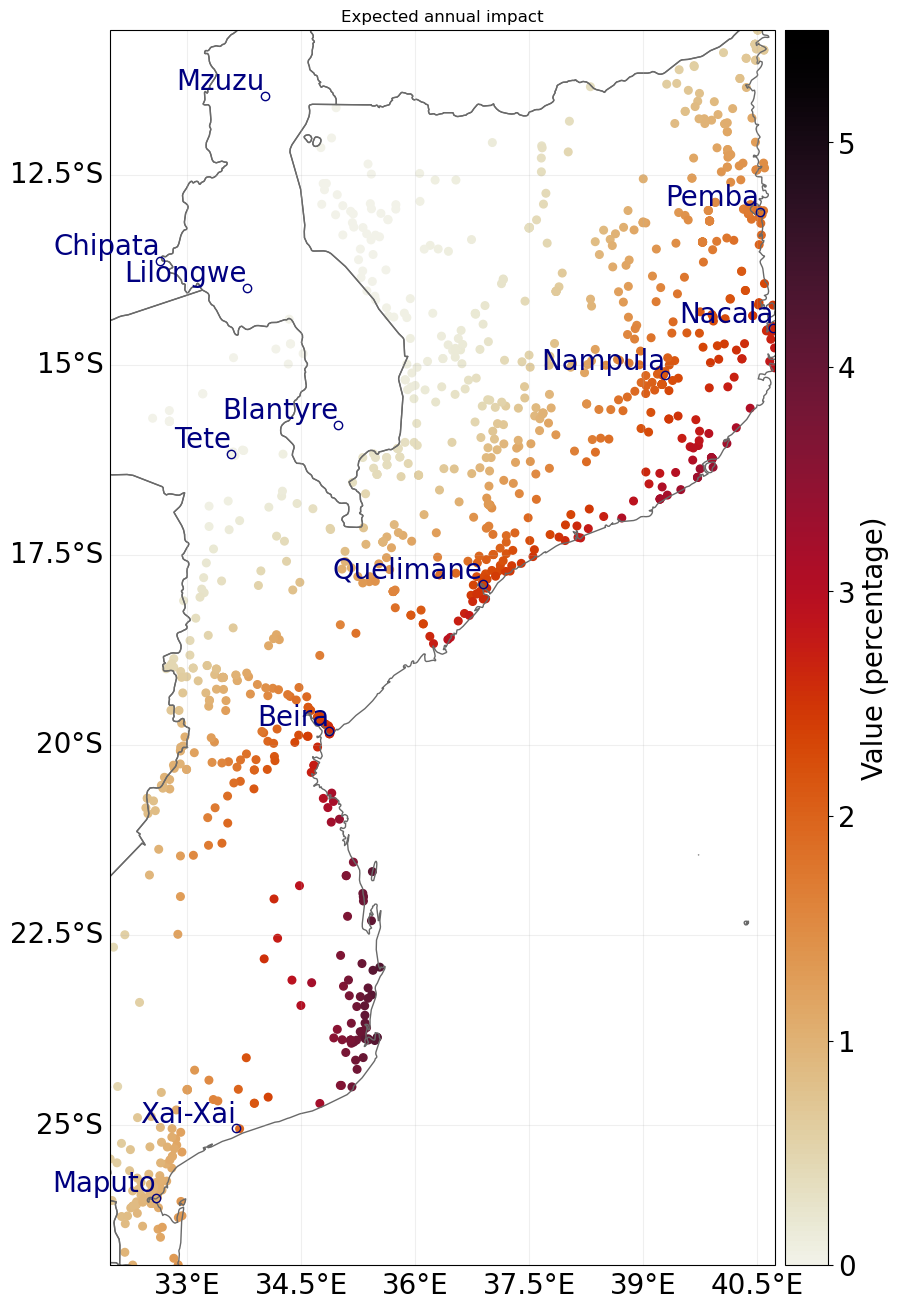

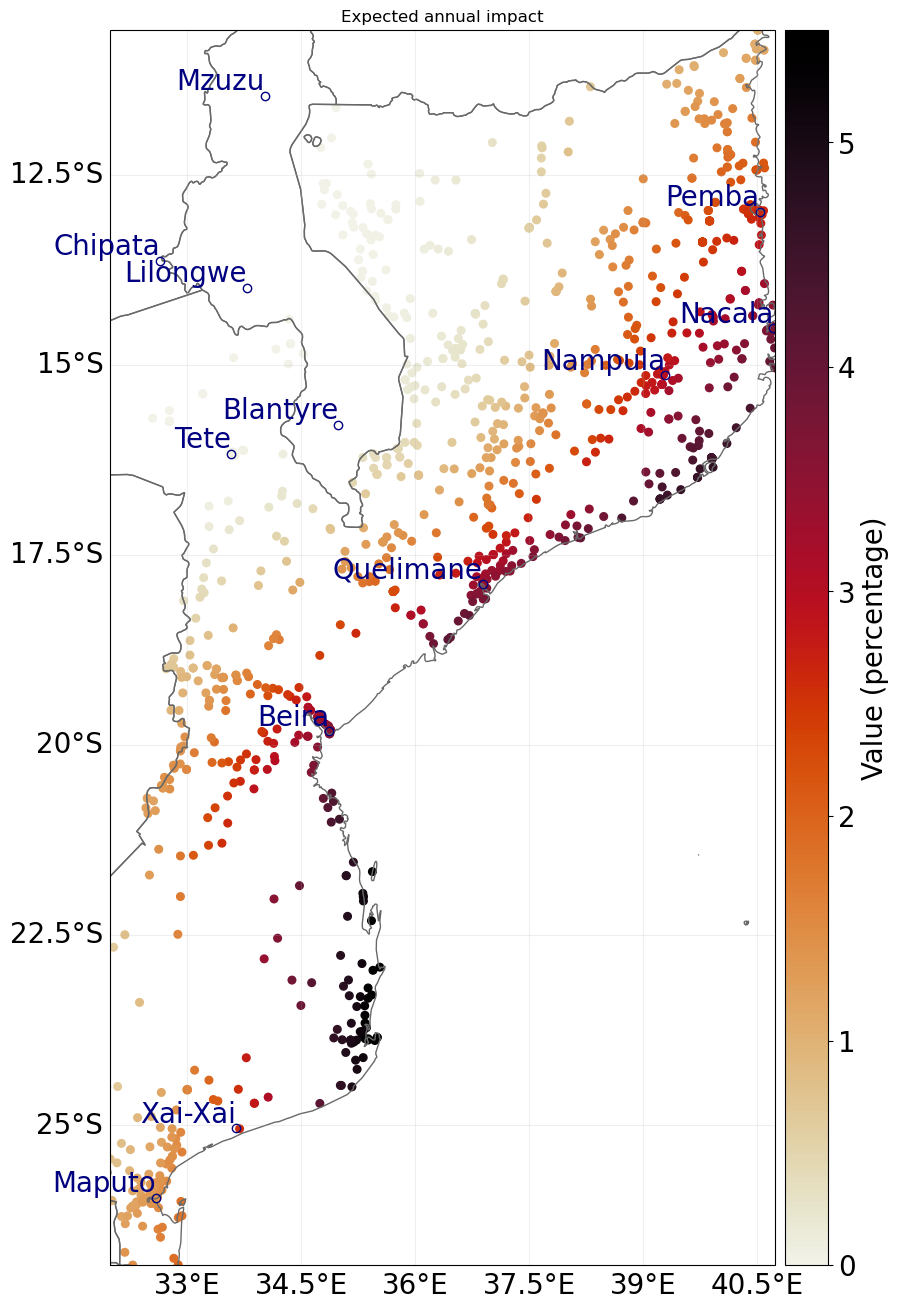

In [64]:
imp_hospitals_present.unit = 'percentage'
imp_hospitals_future.unit = 'percentage'


imp_hospitals_present.plot_scatter_eai_exposure(s=30, vmax=5.5)
imp_hospitals_future.plot_scatter_eai_exposure(s=30, vmax=5.5)

In [52]:
import copy
change_imp = copy.deepcopy(imp_hospitals_present)
change_imp.eai_exp =(imp_hospitals_future.eai_exp - imp_hospitals_present.eai_exp)

<GeoAxesSubplot:title={'center':'Expected annual impact'}>

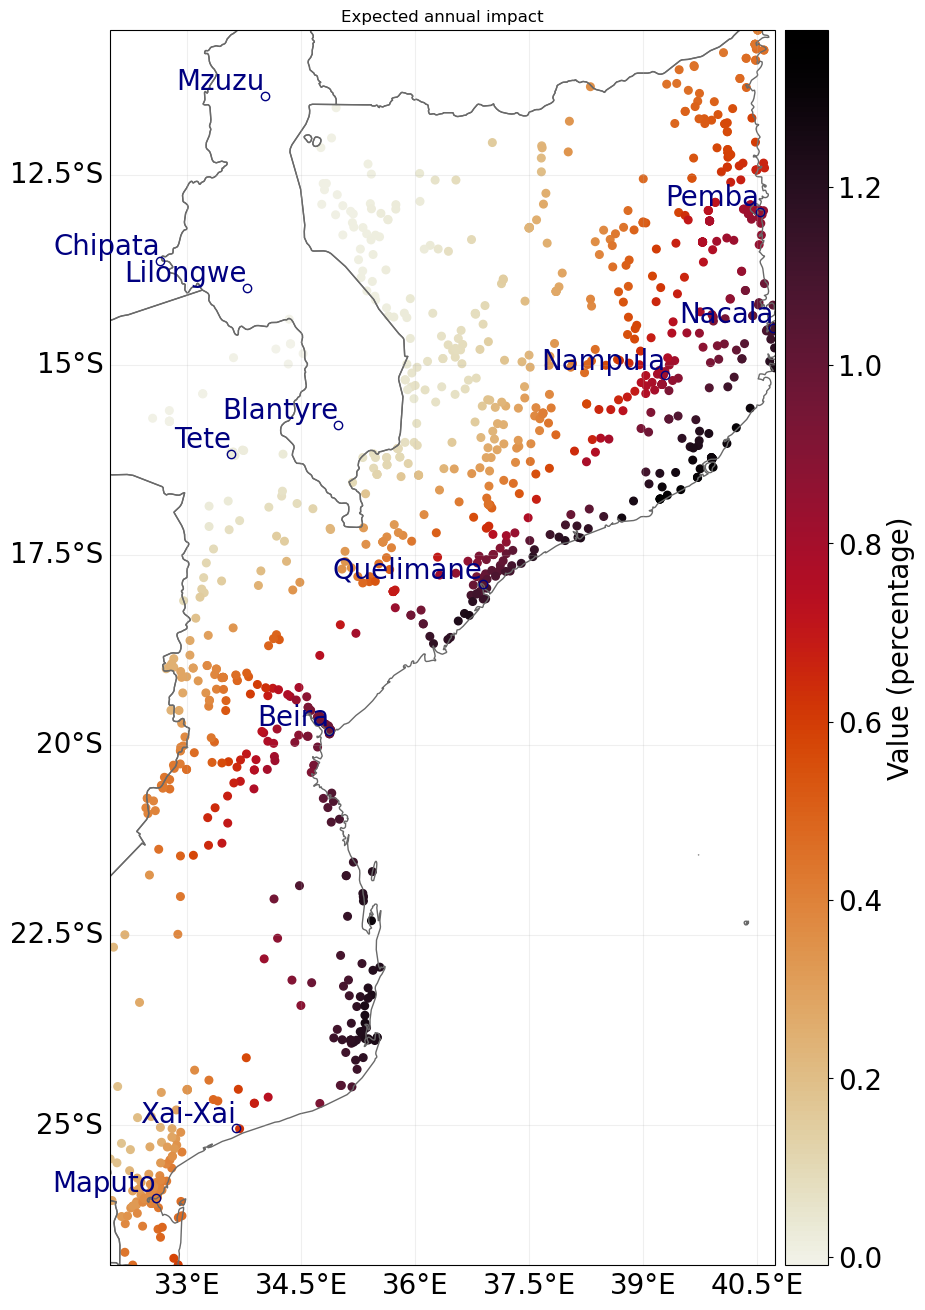

In [53]:
change_imp.plot_scatter_eai_exposure(s=30)

In [22]:
change_exp = np.squeeze(np.asarray(change_imp.eai_exp))

Text(0.5, 0, 'change in damage (%)')

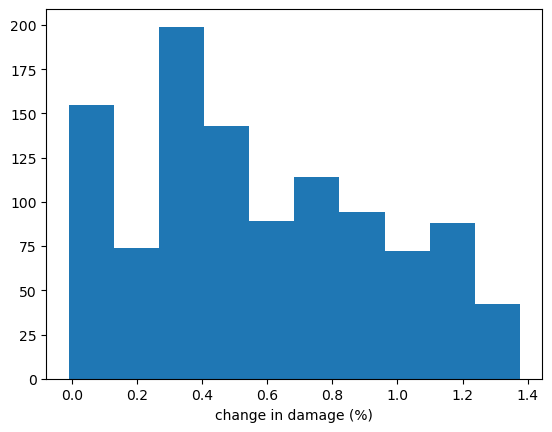

In [24]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.hist(change_exp)
ax.set_xlabel('change in damage (%)')

In [35]:
M = np.mean(imp_hospitals_present.imp_mat.todense(), axis=1)
M = np.squeeze(np.asarray(M))

M2 = np.mean(imp_hospitals_future.imp_mat.todense(), axis=1)
M2 = np.squeeze(np.asarray(M2))

(0.0, 100.0)

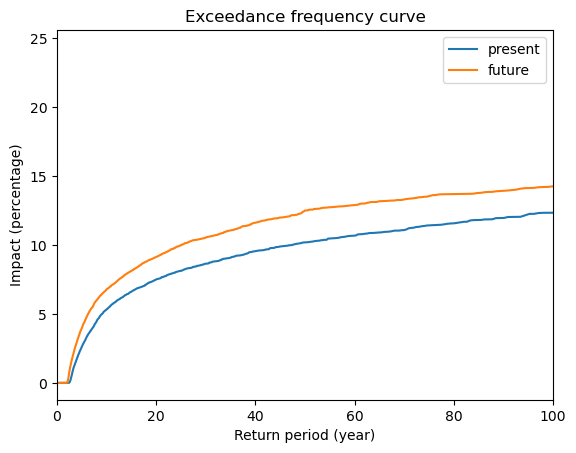

In [55]:
imp_hospitals_present.at_event = M
imp_hospitals_future.at_event = M2
fig, ax = plt.subplots()

imp_hospitals_present.calc_freq_curve().plot(axis=ax, label='present')
imp_hospitals_future.calc_freq_curve().plot(axis=ax,  label='future')
ax.legend()


ax.set_xlim(0,100)

In [43]:
imp_hospitals_present.calc_freq_curve().impact[]

array([1.40291807e-02, 1.40292004e-02, 1.40292201e-02, ...,
       3.33333333e+03, 5.00000000e+03, 1.00000000e+04])

In [58]:
imp_hospitals_future.calc_freq_curve().impact[imp_hospitals_future.calc_freq_curve().return_per>100]

array([14.25391996, 14.25561653, 14.27901274, 14.33705544, 14.34921022,
       14.35072605, 14.376537  , 14.39054027, 14.41501956, 14.58551124,
       14.60391355, 14.62544316, 14.64647669, 14.66352104, 14.70356217,
       14.71937007, 14.73996011, 14.742476  , 14.74793601, 14.76826502,
       14.8033661 , 14.89953219, 14.90241262, 14.91421569, 14.94490778,
       14.99300398, 15.04720466, 15.12623631, 15.16433105, 15.16594195,
       15.25735827, 15.28788832, 15.28916813, 15.2933553 , 15.34027721,
       15.35756947, 15.47954325, 15.52135776, 15.6013915 , 15.70837209,
       15.71710227, 15.73758414, 15.73943234, 15.75310612, 15.79574866,
       15.84507145, 15.87750514, 15.95043403, 15.97697765, 16.06851491,
       16.12509819, 16.24668114, 16.2476508 , 16.25076535, 16.27478201,
       16.28191076, 16.3673638 , 16.42897865, 16.43246933, 16.57913789,
       16.6212296 , 16.66156807, 16.68184455, 16.69444575, 16.76487775,
       16.83090065, 17.08655106, 17.11017976, 17.1183591 , 17.27

In [25]:
imp_hospitals_present.calc_freq_curve().impact[imp_hospitals_present.calc_freq_curve().return_per>100]

array([13197.85514493, 13221.59415937, 13345.84324454, 13387.71452915,
       13472.00752275, 13529.2083406 , 13558.3448986 , 13596.24990812,
       13597.38601128, 13683.60625792, 13734.64337799, 13750.44573689,
       13897.05844242, 13906.10124373, 13914.95832428, 13924.30752765,
       13963.95756342, 13969.67787351, 13980.82924502, 14009.06339332,
       14010.21001434, 14049.91863471, 14051.0200412 , 14070.9045368 ,
       14071.13710995, 14181.60307775, 14189.34241041, 14209.34552218,
       14212.82154982, 14222.55023803, 14227.61972937, 14250.54451303,
       14389.45441991, 14422.36441993, 14448.17767994, 14464.98607572,
       14483.58113301, 14505.25040355, 14524.56125631, 14525.68155565,
       14564.98562167, 14585.83818745, 14665.70972718, 14685.50336772,
       14739.84299503, 14764.6640997 , 14806.72257066, 14862.2735911 ,
       14942.4885211 , 14980.23544867, 15057.67175896, 15081.80579752,
       15086.72454073, 15093.66464548, 15232.85986469, 15268.78909447,
      

In [31]:
from climada.util import coordinates
import copy

impact = imp_hospitals_present
country='508'
lat = np.array([lat for lat, lon in impact.coord_exp])
lon = np.array([lon for lat, lon in impact.coord_exp])
countries_num = coordinates.get_country_code(lat, lon)
countries_num = np.array([format(num, '03d') for num in countries_num])
impact_country = copy.deepcopy(impact)
imp_mat = impact.imp_mat[:, countries_num == country]
#impact_country.coord_exp = impact.coord_exp[countries_num == country]
#impact_country = set_imp_mat(impact_country, imp_mat)
#return impact_country

/Users/szelie/python_projects/climada_python/climada/util/coordinates.py:1446: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  countries['area'] = countries.geometry.area


In [32]:
imp_mat

<712800x1042 sparse matrix of type '<class 'numpy.float64'>'
	with 449404 stored elements in Compressed Sparse Row format>